# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: A surprising demonstration of weight initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [40]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [41]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../ffn/sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [42]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [43]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Explore the weights

In [44]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-0.0117, -0.0296,  0.0735,  ...,  0.0390,  0.0170,  0.0514],
        [ 0.1165,  0.0378, -0.0500,  ...,  0.0044, -0.0366, -0.1017],
        [-0.0596, -0.0541, -0.0609,  ..., -0.0370,  0.0654, -0.1018],
        ...,
        [ 0.0650, -0.0713,  0.1061,  ..., -0.0646, -0.0038, -0.0471],
        [ 0.0678,  0.0406, -0.0669,  ..., -0.0512, -0.0501, -0.0028],
        [ 0.0841, -0.0773, -0.0686,  ..., -0.0334, -0.1026,  0.0465]])


# Create a function that trains the model

In [45]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Let's repeat the experiment with all learnable parameters set to gaussian random numbers with standard deviation between .0001 and 10 in 25 logarithmic steps

In [47]:
stdSteps = np.geomspace(start=0.0001, stop=10, num=25)

trainAccuracy = []

weightsList = []

for i, sigma in enumerate(stdSteps):    
  # Change the weights before training
  net,lossfun,optimizer = createTheMNISTNet()

  # loop over parameters and set them to gaussian
  for p in net.named_parameters():
    p[1].data = torch.normal(mean=torch.tensor(0), std = torch.tensor(sigma), size=p[1].data.shape)

  trnAcc, tstAcc, loss, net = function2trainTheModel(net,lossfun,optimizer)

  trainAccuracy.append(trnAcc)

  allWeights = torch.cat([param.view(-1) for param in net.parameters()]).detach().numpy()
  weightsList.append(allWeights)


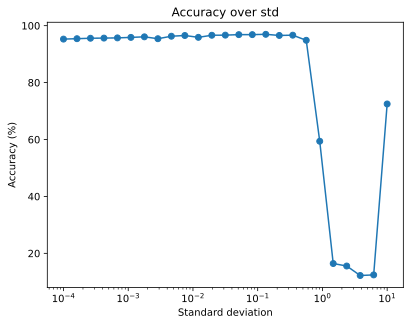

In [48]:
accuracies = [np.mean(x[-4:]) for x in trainAccuracy]

plt.semilogx(stdSteps,accuracies,'o-')
plt.title('Accuracy over std')
plt.xlabel('Standard deviation')
plt.ylabel('Accuracy (%)')
plt.show()




In [49]:
weightsList[1]

array([ 3.78882221e-04, -1.19436416e-04, -2.90441065e-04, ...,
        6.34662271e-01,  9.27490175e-01,  1.10066342e+00], dtype=float32)

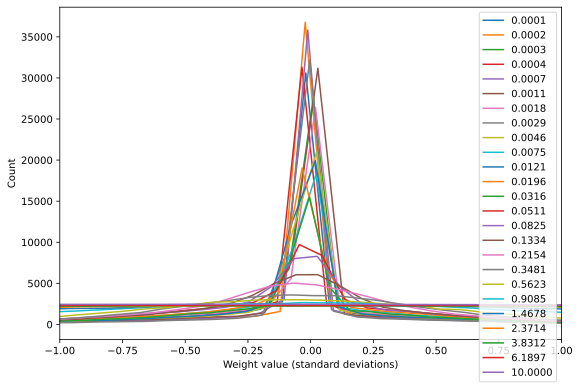

In [50]:
plt.figure(figsize=(9,6))

for i,sigma in enumerate(stdSteps):
   y,x = np.histogram(weightsList[i],80)
   plt.plot((x[1:]+x[:-1])/2,y,label=f'{sigma:.4f}')

plt.xlim(-1.0, 1.0)
plt.legend()
plt.xlabel('Weight value (standard deviations)')
plt.ylabel('Count')
plt.show()
   

# Additional explorations

In [51]:
# 1) You saw that initializing only the weights in fc1 still allowed for good performance, while having all weights be
#    the same value led to HORRIBLE performance. Try setting all weights to ones and all biases to zeros (across all
#    layers). Does that allow for learning? If so, how does it compare to the baseline model performance?
# 
# 2) Now try setting all the weights from all layers to zeros, but leave the bias terms with their initial random values.
# 
# 3) Finally, the opposite of #2: Set all bias terms to zero and leave the weights random. Make a plot of test accuracy
#    performance for the baseline model, weights=0, and biases=0.
# 